In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install scikit-lego
!pip install polars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.9/230.9 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=00a757e9118bea9600bd2e0619c1438fcf28cc3dfd50889d198f5cbeaa285d80
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=82c3b6f2a7a17a94208c1f1f5c954fc1554538b9ba400135aea68209448e0b0e
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


In [ ]:
import copy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import stats
from scipy.stats import norm

import xgboost as xgb
import lightgbm as lgb

import os
os.chdir("/content/drive/My Drive/practicum_data/")
#from google.colab import drive
#drive.mount('/content/drive')

from share_funcs import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Parameters

# American Call Option - RF

In [ ]:
# Read data
data = pd.read_csv("/content/drive/MyDrive/practicum_data-American_Option/eurocall_fourier2.csv", index_col=0)
data.dropna(axis=0, how='any', inplace=True)
data.head()

,m,T,r,q,v0,theta,kappa,sigma,rho,eurocall_fourier
0,4.258717,1.680247,0.016304,0.041019,0.323511,1.807475,1.571375,0.067568,-0.773899,0.191405
1,2.274916,1.804915,0.058924,0.027882,0.496085,1.162404,0.670037,0.097001,-0.533752,0.226636
2,4.534160,0.670730,0.020643,0.030725,0.091455,1.815181,0.991059,0.493723,-0.425484,0.001174
3,4.753463,0.846062,0.026829,0.042381,0.145451,1.897037,0.809850,0.138594,-0.069301,0.007853
4,0.673201,0.114297,0.023764,0.021375,0.271200,0.301441,1.161399,0.331472,-0.601016,0.327119


In [ ]:
((data['eurocall_fourier'] > 0) & (data['eurocall_fourier'] < 1e-5)).value_counts()

False    50000
Name: eurocall_fourier, dtype: int64

In [ ]:
# Remove < 1e-5
# data0 = copy.deepcopy(data)
data['eurocall_fourier'] = data['eurocall_fourier'].apply(lambda x: 0 if x < 1e-5 else x)
data[data['eurocall_fourier'] == 0].shape

(5135, 10)

In [ ]:
data[data.eurocall_fourier == 0].shape

(5135, 10)

In [ ]:
# Data set
rf_data = copy.deepcopy(data)

# Split train/test data set
X_rf = rf_data.drop(['eurocall_fourier'], axis=1)
y_rf = rf_data['eurocall_fourier']
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.3, random_state=10)

## Model Fit

In [ ]:
# Model fit
%%time
trained_params_rf = {'n_estimators': [50, 100, 200, 400],
                     'max_features': np.arange(1, 9)
                     }
grid_search_rf = trainmodel(RandomForestRegressor, X_train_rf, y_train_rf, trained_params_rf)
rf_cv_results = pd.DataFrame(grid_search_rf.cv_results_)

KeyboardInterrupt: ignored

In [ ]:
file_path_rf = '/content/drive/MyDrive/Practicum/rf_cv_results_1w.csv'
#rf_cv_results.to_csv(file_path_rf)
rf_cv_results = pd.read_csv(file_path_rf, index_col=0)

In [ ]:
%%time
rfr1 = train_best_reg(RandomForestRegressor, X_train_rf, y_train_rf, X_test_rf, y_test_rf,
                      "RF", max_features=5, n_estimators=500)

Current Best RF Performance:
RandomForestRegressor(max_features=5, n_estimators=500)
Train Set rmse:  0.00561
RF rmse:  0.01554 mae: 0.00957
RF r2:  0.99348
CPU times: user 1min 49s, sys: 873 ms, total: 1min 49s
Wall time: 1min 50s


In [ ]:
%%time
rfr2 = train_best_reg(RandomForestRegressor, X_train_rf, y_train_rf, X_test_rf, y_test_rf,
                      "RF", max_features=5, n_estimators=400)

Current Best RF Performance:
RandomForestRegressor(max_features=5, n_estimators=400)
Train Set rmse:  0.00565
RF rmse:  0.01566 mae: 0.00961
RF r2:  0.99338
CPU times: user 1min 24s, sys: 946 ms, total: 1min 25s
Wall time: 1min 25s


In [ ]:
def train_best(model, X_train: pd.DataFrame, y_train: Union[pd.DataFrame, pd.Series], X_test: pd.DataFrame,
              y_test:Union[pd.DataFrame, pd.Series], name: str="Model", **kwargs):
  model_instance = model(**kwargs)
  model_instance.fit(X_train, y_train)
  print(f"Current Best {name} Performance:")
  print(model_instance)
  # y_test_predict = err_check(model_instance.predict(X_test))
  y_test_predict = model_instance.predict(X_test)
  rmse = np.around(np.sqrt(mean_squared_error(y_test, y_test_predict)), decimals=5)
  mae = np.around(mean_absolute_error(y_test, y_test_predict), decimals=5)
  r2 = np.around(r2_score(y_test, y_test_predict), decimals=5)
  print("Train Set rmse: ", np.around(np.sqrt(mean_squared_error(y_train, model_instance.predict(X_train))), decimals=5))
  print(f"{name} rmse: ", rmse, "mae:", mae)
  #print(f"{name} r2: ", r2)
  return model_instance,rmse

score_lt = []
nrange=[400,550,600]
for i in range(25,30,1):
  rfc = train_best(RandomForestRegressor, X_train_rf, y_train_rf, X_test_rf, y_test_rf,
                      "RF", max_features=5, n_estimators=400,max_depth=i)
  score = rfc[1]
  score_lt.append(score)
score_max = max(score_lt)

print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)*10+1))

# 绘制学习曲线
plt.subplot(111)
plt.plot(score_lt, 'r-')
plt.xlabel('n estimators')
plt.ylabel('rsme')
plt.show()

Current Best RF Performance:
RandomForestRegressor(max_depth=25, max_features=5, n_estimators=400)
Train Set rmse:  0.00567
RF rmse:  0.0156 mae: 0.00961
Current Best RF Performance:
RandomForestRegressor(max_depth=26, max_features=5, n_estimators=400)
Train Set rmse:  0.0056
RF rmse:  0.01561 mae: 0.00961
Current Best RF Performance:
RandomForestRegressor(max_depth=27, max_features=5, n_estimators=400)
Train Set rmse:  0.00562
RF rmse:  0.01567 mae: 0.00961


## Error Analysis

In [ ]:
# Error
# using model with n estimators = 400
y_test_predict_rf = err_check(rfr2.predict(X_test_rf))
err_rf = y_test_rf - y_test_predict_rf

print('RF Absolute Error (quantile): ')
print(np.around(err_rf.abs().quantile([0, 0.25, 0.5, 0.75, 0.85, 0.9, 0.99, 1]), decimals=3))

RF Absolute Error (quantile): 
0.00    0.000
0.25    0.001
0.50    0.005
0.75    0.014
0.85    0.020
0.90    0.025
0.99    0.053
1.00    0.526
Name: eurocall_fourier, dtype: float64


## Feature Importance

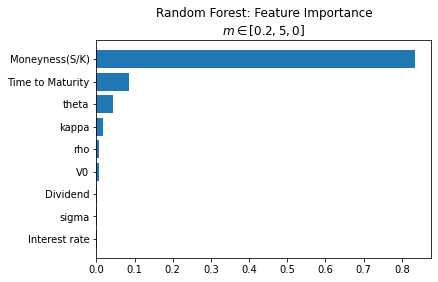

In [ ]:
# Model Feature Importance
rf_feature_importance = pd.Series(rfr2.feature_importances_ / rfr2.feature_importances_.sum(),
                                  index=['Moneyness(S/K)', 'Time to Maturity', 'Interest rate', 'Dividend','V0','theta','kappa','sigma','rho']).sort_values()
plt.barh(rf_feature_importance.index, rf_feature_importance)
plt.title("Random Forest: Feature Importance\n$m \in [0.2, 5,0]$");

# American Call Option - XGBoost

In [ ]:
xgb_data = copy.deepcopy(data)

# train/test data set for XGB
X_xgb = xgb_data.drop(['eurocall_fourier'], axis=1)
y_xgb = xgb_data['eurocall_fourier']
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.3, random_state=10)

In [ ]:
y_xgb_classify = (y_xgb > 0).astype(np.int64)

y_train_xgb_classify = y_xgb_classify[y_train_xgb.index]
y_test_xgb_classify = y_xgb_classify[y_test_xgb.index]


In [ ]:
#98.52

In [ ]:
tmp_xgb_clf1= train_best_clf(xgb.XGBClassifier, X_train_xgb, y_train_xgb_classify,X_test_xgb,y_test_xgb_classify,"xgb classifier", **{'eta':0.03,'colsample_bytree': 1, 'reg_alpha': 0,'reg_lambda': 1, 'max_depth':6, 'min_child_weight': 1, 'n_estimators': 800, 'subsample': 0.8})

Current Best xgb classifier Performance:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.03,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)
Train Set rmse:  0.009258200997725514
xgb classifier rmse:  0.11860297916438131 mae: 0.014066666666666667
Accuracy 0.9859333333333333


## Model Fit

In [ ]:
param_xgb = {'n_estimators': [200, 400, 800],
             'subsample': [0.6, 0.8],
             'colsample_bytree': [0.8, 1],
             'lambda_l2': [0, 1],
             'min_child_weight': [1, 5, 10],
             'max_depth': [4, 5, 6]
             }
grid_xgb = trainmodel(xgb.XGBRegressor, X_train_xgb, y_train_xgb, param_xgb)
xgb_cv_results = pd.DataFrame(grid_xgb.cv_results_)

In [ ]:
file_path_xgb = '/content/drive/MyDrive/Practicum/xgb_cv_results_1w.csv'
#xgb_cv_results.to_csv(file_path_xgb)
xgb_cv_results = pd.read_csv(file_path_xgb, index_col=0)

In [ ]:
xgb1 = train_best_reg(xgb.XGBRegressor, X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb,
                      'XGB', **{'eta':0.05,'colsample_bytree': 0.8, 'reg_alpha': 0,'reg_lambda': 0, 'min_child_weight': 1, 'n_estimators': 3200, 'subsample': 1, 'max_depth':6})

Current Best XGB Performance:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=3200, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)
Train Set rmse:  0.00255
XGB rmse:  0.0079 mae: 0.00537
XGB r2:  0.99832


In [ ]:
**{'eta':0.04,'colsample_bytree': 0.8, 'reg_alpha': 0,'reg_lambda': 0, 'min_child_weight': 1, 'n_estimators': 3200, 'subsample': 1, 'max_depth':6}

In [ ]:
xgb2 = train_best_reg(xgb.XGBRegressor, X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb,
                      'XGB', **{'eta':0.1,'colsample_bytree': 0.8, 'reg_alpha': 0,'reg_lambda': 0, 'min_child_weight': 1, 'n_estimators': 800, 'subsample': 0.8, 'max_depth':7,'objective':"reg:absoluteerror"})

Current Best XGB Performance:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=800, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)
Train Set rmse:  0.07814
XGB rmse:  0.33198 mae: 0.23804
XGB r2:  -1.9768


## Error Analysis

In [ ]:
# Error
y_test_predict_xgb = pd.Series(xgb2.predict(X_test_xgb), index=y_test_xgb.index)
err_xgb = y_test_xgb - y_test_predict_xgb

print('XGM Absolute Error (quantile): ')
print(np.around(err_xgb.abs().quantile([0, 0.25, 0.5, 0.75, 0.85, 0.9, 0.99, 1]), decimals=3))

XGM Absolute Error (quantile): 
0.00    0.000
0.25    0.043
0.50    0.095
0.75    0.177
0.85    0.240
0.90    0.288
0.99    0.606
1.00    2.057
dtype: float64


In [ ]:
y_test_predict_xgb[y_test_xgb == 0].abs().sort_values(ascending=False)

14677    0.294958
9870     0.100801
18467    0.031527
34128    0.030500
34740    0.030207
13348    0.024857
61       0.023989
10232    0.021721
2518     0.021375
39201    0.020086
31740    0.019901
22856    0.019762
36324    0.019628
35749    0.019460
45210    0.018851
21010    0.017913
29642    0.017270
39226    0.015994
1275     0.015953
47601    0.015356
26613    0.015033
24035    0.014926
15533    0.014643
21001    0.014228
29120    0.014081
10307    0.014078
9923     0.013864
6051     0.013857
28810    0.013541
4349     0.013338
4088     0.013213
26937    0.013098
14981    0.013022
3243     0.012591
32642    0.012558
14340    0.012452
21100    0.012383
43555    0.012301
36806    0.012070
24344    0.011955
2794     0.011653
29487    0.010982
20046    0.010982
45566    0.010826
10740    0.010678
31958    0.010542
20661    0.010463
49397    0.010447
19535    0.010236
17616    0.010103
44693    0.010055
42514    0.009845
9888     0.009712
11487    0.009709
29497    0.009694
4823     0

## Feature Importance

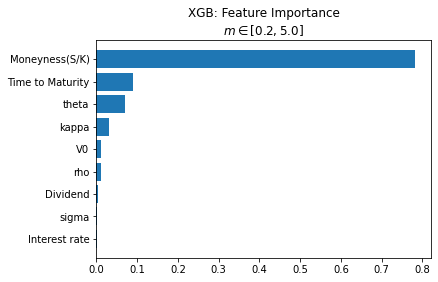

In [ ]:
# Model Feature Importance
xgb_feature_importance = pd.Series(xgb2.feature_importances_ / xgb2.feature_importances_.sum(),
                                   index=['Moneyness(S/K)', 'Time to Maturity', 'Interest rate', 'Dividend','V0','theta','kappa','sigma','rho']).sort_values()
plt.barh(xgb_feature_importance.index, xgb_feature_importance)
plt.title("XGB: Feature Importance\n$m \in [0.2, 5.0]$");

# American Call Option - LightGBM

In [ ]:
lgb_data = copy.deepcopy(data)

# train/test data set for LGBM
X_lgb = lgb_data.drop(['eurocall_fourier'], axis=1)
y_lgb = lgb_data['eurocall_fourier']
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X_lgb, y_lgb, test_size=0.3, random_state=10)

## Model Fit

In [ ]:
param_lgb = {'num_leaves': [17, 31, 63],
             'max_bins': [31 ,63, 127],
             'min_data_in_leaf': [30, 60, 90],
             'lambda_l1': [0, 0.1, 0.5],
             'lambda_l2': [0, 1],
             'num_estimators': [200, 400]
             }
# {'lambda_l1': 0, 'lambda_l2': 1, 'max_bins': 31, 'min_data_in_leaf': 30, 'num_leaves': 31,'n_estimators':400}

grid_lgb = trainmodel(lgb.LGBMRegressor, X_train_lgb, y_train_lgb, param_lgb)
lgb_cv_results = pd.DataFrame(grid_lgb.cv_results_)

KeyboardInterrupt: ignored

In [ ]:
file_path_lgb = '/content/drive/MyDrive/Practicum/lgb_cv_results_1w.csv'
#lgb_cv_results.to_csv(file_path_lgb)
lgb_cv_results = pd.read_csv(file_path_lgb, index_col=0)

In [ ]:
lgb1 = train_best_reg(lgb.LGBMRegressor, X_train_lgb, y_train_lgb, X_test_lgb, y_test_lgb,
                      'LGB', **{'lambda_l1': 0.1, 'lambda_l2':1, 'max_bins': 31,'num_estimators':200, 'num_leaves': 31, 'min_data_in_leaf': 30})

Current Best LGB Performance:
LGBMRegressor(lambda_l1=0.1, lambda_l2=1, max_bins=31, min_data_in_leaf=30,
              num_estimators=200)
Train Set rmse:  0.01726
LGB rmse:  0.01913 mae: 0.01206
LGB r2:  0.99012


## Error Analysis

In [ ]:
# Error
y_test_predict_lgb = err_check(lgb1.predict(X_test_lgb))
err_lgb = y_test_lgb - y_test_predict_lgb

print('LGB Absolute Error (quantile): ')
print(np.around(err_lgb.abs().quantile([0, 0.25, 0.5, 0.75, 0.85, 0.9, 0.99, 1]), decimals=3))

LGB Absolute Error (quantile): 
0.00    0.000
0.25    0.002
0.50    0.005
0.75    0.011
0.85    0.016
0.90    0.019
0.99    0.039
1.00    0.647
Name: eurocall_fourier, dtype: float64


## Feature Importance

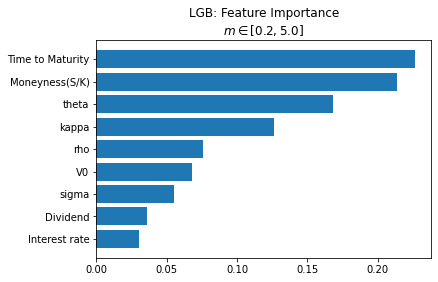

In [ ]:
# Model Feature Importance
lgb_feature_importance = pd.Series(lgb1.feature_importances_ / lgb1.feature_importances_.sum(),
                                   index=['Moneyness(S/K)', 'Time to Maturity', 'Interest rate', 'Dividend','V0','theta','kappa','sigma','rho']).sort_values()
plt.barh(lgb_feature_importance.index, lgb_feature_importance)
plt.title("LGB: Feature Importance\n$m \in [0.2, 5.0]$");

# American Call Option - ANN

In [ ]:
X_ann = data.drop(columns=['eurocall_fourier'], axis=1)
#X_ann = X_ann.drop(columns=['g_eurocall'], axis=1)
y_ann = data['eurocall_fourier']

#X_ann['T_sigma'] = X_ann.g_T * X_ann.g_sigma
X_ann['T_q'] = X_ann.g_T * X_ann.g_q
X_ann['T_r'] = X_ann.g_T * X_ann.g_r

X_train_ann, X_test_ann, y_train_ann, y_test_ann = train_test_split(X_ann, y_ann, test_size=0.3, random_state=10)
#train_size = int(0.8 * len(X_train_ann))
#X_train_ann, X_val_ann, y_train_ann, y_val_ann = train_test_split(X_train_ann, y_train_ann, test_size=0.3, random_state=10)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-57-8c98b4abf13b>", line 6, in <module>
    X_ann['T_q'] = X_ann.g_T * X_ann.g_q
  File "/usr/local/lib/python3.9/dist-packages/pandas/core/generic.py", line 5487, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'g_T'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/ultra

AttributeError: ignored

## Model Fit

In [ ]:
class PricingNetwork2(nn.Module):
  def __init__(self, mean=X_train_ann.mean(axis=0).values.astype(np.float32), std=X_train_ann.std(axis=0).values.astype(np.float32), neurons=64, x_features=X_train_ann.shape[1]):
  #def __init__(self, neurons=64, x_features=5):
    super(PricingNetwork2,self).__init__()
    self.mean = mean
    self.std = std
    self.bottleneck = nn.Sequential(nn.Linear(x_features, neurons), nn.LeakyReLU(),
                                     nn.Linear(neurons, neurons), nn.LeakyReLU(),
                                     nn.Linear(neurons, neurons), nn.LeakyReLU(),
                                     nn.Linear(neurons, neurons), nn.LeakyReLU(),
                                     #nn.Linear(neurons, neurons), nn.LeakyReLU(),
                                     nn.Linear(neurons, neurons), nn.LeakyReLU())
    #self.bottleneck = nn.ModuleList([nn.Linear(x_features, neurons), nn.LeakyReLU()] + [nn.Linear(neurons, neurons), nn.LeakyReLU()] * 4)
    self.final_layer = nn.Linear(neurons, 1)

  def forward(self, X, **kwargs):
    #X = (X - np.array([2.59564865,1.00528802,0.03986204,0.02523768,1.06051767], dtype=np.float32)) / np.array([1.38237971, 0.57541136, 0.02325452, 0.01445998, 0.55268058],dtype=np.float32)
    #(X - X.mean(axis=0))/X.std(axis=0)
    X = (X - self.mean) / self.std
    X = self.bottleneck(X)
    X  = self.final_layer(X)
    return X

## Error Analysis

In [ ]:
ann_model = torch.load('/content/drive/MyDrive/practicum_data-American_Option/with_eurocall.pt')

print('ANN Absolute Error (quantile): ')
with torch.no_grad():
  err_ann = np.around((y_test_ann - pd.Series(ann_model(torch.tensor(X_test_ann.values.astype(np.float32))).flatten(), index=X_test_ann.index)), decimals=3)
print((err_ann.abs().quantile([0,0.25,0.5,0.75,0.85,0.9,0.99,1])))

ANN Absolute Error (quantile): 
0.00    0.000
0.25    0.000
0.50    0.000
0.75    0.001
0.85    0.002
0.90    0.002
0.99    0.005
1.00    0.026
dtype: float64


# Summary

In [ ]:
err_table = pd.concat([X_test_rf, err_rf.abs(), err_xgb.abs(), err_lgb.abs()], axis=1)
err_table.columns = ['g_m', 'g_T', 'g_r', 'g_q',   'abs_err_rf', 'abs_err_xgb', 'abs_err_lgb']
err_table.head()

,g_m,g_T,g_r,g_q,abs_err_rf,abs_err_xgb,abs_err_lgb
27632,3.287892,1.759296,0.001603,0.033519,0.000004,0.000029,0.000008
36119,1.486242,1.967973,0.039346,0.042800,0.001425,0.000589,0.001674
4796,1.621878,0.671125,0.065681,0.021802,0.000032,0.000948,0.000562
3648,4.271923,1.674382,0.008339,0.005231,0.000000,0.000310,0.000082
24501,2.671971,1.813944,0.076365,0.014438,0.000017,0.000070,0.000205


## Moneyness

In [ ]:
print('#OTM = ', err_table[err_table['g_m'] > 1].shape[0], '; %OTM = ', err_table[err_table['g_m'] > 1].shape[0]/err_table.shape[0])
print('#ATM = ', err_table[err_table['g_m'] == 1].shape[0], '; %ATM = ', err_table[err_table['g_m'] == 1].shape[0]/err_table.shape[0])
print('#ITM = ', err_table[err_table['g_m'] < 1].shape[0], '; %OTM = ', err_table[err_table['g_m'] < 1].shape[0]/err_table.shape[0])

#OTM =  12498 ; %OTM =  0.8332
#ATM =  0 ; %ATM =  0.0
#ITM =  2502 ; %OTM =  0.1668


In [ ]:
# OTM
np.around(err_table[err_table['g_m'] > 1].quantile([0,0.25,0.5,0.75,0.85,0.90,0.95,0.99,1]), decimals=3)

,g_m,g_T,g_r,g_q,g_sigma,g_eurocall,abs_err_rf,abs_err_xgb,abs_err_lgb,abs_err_ann
0.00,1.000,0.011,0.000,0.000,0.051,0.000,0.000,0.000,0.000,0.000
0.25,2.035,0.088,0.021,0.013,0.514,0.000,0.000,0.000,0.000,0.000
0.50,3.024,0.277,0.040,0.026,0.983,0.005,0.000,0.000,0.000,0.000
0.75,4.000,1.047,0.060,0.038,1.456,0.118,0.000,0.000,0.001,0.001
0.85,4.402,1.449,0.068,0.042,1.689,0.243,0.001,0.001,0.001,0.002
0.90,4.588,1.699,0.071,0.045,1.785,0.345,0.001,0.001,0.001,0.002
0.95,4.809,2.044,0.076,0.047,1.906,0.488,0.001,0.001,0.002,0.003
0.99,4.964,2.044,0.079,0.050,1.979,0.655,0.003,0.002,0.003,0.004
1.00,4.999,2.044,0.080,0.050,2.000,0.805,0.013,0.005,0.008,0.009


In [ ]:
# ITM
np.around(err_table[err_table['g_m'] < 1].quantile([0,0.25,0.5,0.75,0.85,0.90,0.95,0.99,1]), decimals=3)

,g_m,g_T,g_r,g_q,g_sigma,g_eurocall,abs_err_rf,abs_err_xgb,abs_err_lgb,abs_err_ann
0.00,0.201,0.011,0.000,0.000,0.051,0.022,0.000,0.000,0.000,0.000
0.25,0.364,0.088,0.020,0.014,0.504,0.338,0.000,0.000,0.001,0.001
0.50,0.577,0.277,0.040,0.026,0.984,0.519,0.001,0.001,0.001,0.002
0.75,0.792,1.047,0.061,0.038,1.434,0.685,0.002,0.001,0.003,0.002
0.85,0.874,1.449,0.069,0.042,1.686,0.738,0.002,0.002,0.003,0.003
0.90,0.917,1.699,0.072,0.045,1.782,0.760,0.003,0.002,0.004,0.004
0.95,0.960,2.044,0.077,0.047,1.898,0.784,0.004,0.003,0.005,0.005
0.99,0.993,2.044,0.079,0.050,1.967,0.827,0.010,0.007,0.011,0.007
1.00,1.000,2.044,0.080,0.050,2.000,0.912,0.036,0.026,0.045,0.026
